# Assessing building fire risk with Random Forest
** *Combining different governmental datasets to prioritize fire department resources* **

## Background

Fire departments across the United States spend considerable resources on educational and prevention campaigns to stop building fires before they happen. Moving from a shotgun approach to a targeted one that considers the likelihood of  fire incidents could significantly improve the efficacy of these interventions. To do this, machine learning algorithms built on data from a wide variety of sources could vastly improve how we perform against randomness. 

Using data provided by the city of Sioux Falls, this notebook walks through the steps of predicting fire risk for every address listed in the city with a random forest classifier algorithm written in Python, and trained on data coming from several different county and municipal departments.


## Import libraries

In [1]:
# Data analysis and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Interactive maps 
import folium
from folium.plugins import HeatMap

# Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

## Load and describe the data

In [2]:
# Load the data into Python
fires_df = pd.read_csv('data/fires2.csv', parse_dates=[6])
parcels_df = pd.read_excel('data/parcels2.xlsx', parse_dates=True)
foreclosures_df = pd.read_excel('data/foreclosures.xlsx', parse_dates=True)
rent_reg_df = pd.read_excel('data/rental_registration_permits.xlsx', parse_dates=True)
utility_disconnects_df = pd.read_excel('data/utility_disconnects.xlsx', parse_dates=True)
code_cases_df = pd.read_excel('data/code_cases.xlsx', parse_dates = True)
minnehaha_tax_df = pd.read_excel('data/minnehaha_tax.xlsx', parse_dates = True)
lincoln_tax_df = pd.read_excel('data/lincoln_tax.xlsx', parse_dates = True)
crime_df = pd.read_excel('data/crime.xlsx', parse_dates = True)

C:\Users\User\Anaconda3\lib\site-packages\pandas\io\excel.py:520: UserWarning: The 'parse_dates=True' keyword of read_excel was provided without an 'index_col' keyword value.
  warn("The 'parse_dates=True' keyword of read_excel was provided"
C:\Users\User\Anaconda3\lib\site-packages\pandas\io\excel.py:520: UserWarning: The 'parse_dates=True' keyword of read_excel was provided without an 'index_col' keyword value.
  warn("The 'parse_dates=True' keyword of read_excel was provided"
C:\Users\User\Anaconda3\lib\site-packages\pandas\io\excel.py:520: UserWarning: The 'parse_dates=True' keyword of read_excel was provided without an 'index_col' keyword value.
  warn("The 'parse_dates=True' keyword of read_excel was provided"
C:\Users\User\Anaconda3\lib\site-packages\pandas\io\excel.py:520: UserWarning: The 'parse_dates=True' keyword of read_excel was provided without an 'index_col' keyword value.
  warn("The 'parse_dates=True' keyword of read_excel was provided"
C:\Users\User\Anaconda3\lib\site

In [3]:
fires_df.type.value_counts()

Building fire                                               1258
Passenger vehicle fire                                       639
Cooking fire, confined to container                          244
Grass fire                                                   198
Dumpster or other outside trash receptacle fire              183
Outside rubbish, trash or waste fire                         124
Brush, or brush and grass mixture fire                        94
Special outside fire, other                                   91
Outside equipment fire                                        80
Fire, other                                                   71
Mobile property (vehicle) fire, other                         71
Natural vegetation fire, other                                70
Trash or rubbish fire, contained                              64
Outside rubbish fire, other                                   57
Fire in mobile home used as fixed residence                   56
Road freight or transport

In [4]:
# Create copys of DataFrames so if I mess something up I don't have to load up everything again
building_fires = fires_df[fires_df['id2']== 111].copy()
parcels = parcels_df.copy()
foreclosures = foreclosures_df.copy()
rent_reg = rent_reg_df.copy()
utility_disconnects = utility_disconnects_df.copy()
code_cases = code_cases_df.copy()
minnehaha_tax = minnehaha_tax_df.copy()
lincoln_tax = lincoln_tax_df.copy()
crime = crime_df.copy()

In [5]:
parcels.columns

Index(['TAG', 'COUNTYID', 'ADDRESS', 'OWNNAME1', 'OWNNAME2', 'OWNADDRESS',
       'OWNCITY', 'OWNSTATE', 'OWNZIP', 'OWNZIP2', 'SQFT', 'ACREAGE',
       'FRONTFOOT', 'LEGAL', 'ADDITION', 'ADDITIONNU', 'PARHOUSE', 'PARHALF',
       'PARPR', 'PARSTREET', 'PARTYPE', 'PARPD', 'UNITNUM', 'ACTIVITY',
       'LANDUSE', 'NUMUNITS', 'COUNTY', 'LegalStart', 'GlobalID', 'created_us',
       'created_da', 'last_edite', 'last_edi_1', 'ADDITIONPR', 'PARCEL_LOT',
       'PARCEL_TRA', 'BlockDesig', 'FORM_PRIMA', 'FORM_ACCES', 'FORM_SIGNE',
       'FORM_DATE', 'FORM_COMME', 'DEPARTMENT', 'PARCELTYPE', 'ZIPCODE',
       'Shape_Leng', 'Shape_Area'],
      dtype='object')

In [6]:
foreclosures.describe()

,ASSESSEDVALUE,YEAR
count,1.974000e+03,1982.000000
mean,1.281877e+05,2011.934914
std,8.889734e+04,2.875913
min,0.000000e+00,2008.000000
25%,8.446325e+04,2010.000000
50%,1.136345e+05,2012.000000
75%,1.453120e+05,2014.000000
max,1.562129e+06,2019.000000


In [7]:
building_fires.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1258 entries, 652 to 2318
Data columns (total 10 columns):
FID           1258 non-null int64
Join_Count    1258 non-null int64
TARGET_FID    1258 non-null int64
id            1258 non-null int64
id2           1258 non-null int64
type          1258 non-null object
date          1258 non-null datetime64[ns]
lat           1258 non-null float64
lon           1258 non-null float64
ADDRESS       1258 non-null object
dtypes: datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 108.1+ KB


In [8]:
# Visualizing the fire incidents in a map
fire_map = folium.Map(location=[43.54, -96.72], zoom_start=14, tiles='Stamen Terrain')
heat_df = building_fires[['lat', 'lon']]
heat_df = heat_df.dropna(axis=0, subset=['lat','lon'])
heat_data = [[row['lat'],row['lon']] for index, row in heat_df.iterrows()]
HeatMap(heat_data).add_to(fire_map)
fire_map

## Data wrangling

In [9]:
def cleanActivity(x):
    if x == 11 or x == 12 or x == 13:
        x = 'SINGLE OR TWO RESIDENTIAL'
    elif x == 21 or x == 22 or x == 23 or x == 24 or x == 25:
        x = 'MULTIFAMILY'
    elif x in list(range(31,39)):
        x = 'OFFICE AND PUBLIC SERVICE'
    elif x in list(range(40,50)):
        x = 'INSTITUTIONAL'
    elif x in list(range(51, 54)):
        x = 'COMMERCIAL'
    elif x == 61 or x in list(range(63,70)):
        x = 'INDUSTRIAL'
    elif x == 62:
        x = 'AIRPORT'
    elif x in range(70,98) or x in range(0, 9):
        x = 'OPEN SPACES/NA'
    return x


parcels['ACTIVITY'] = parcels.ACTIVITY.apply(cleanActivity)

# Parcels dataset
df = pd.concat([parcels, pd.get_dummies(parcels.ACTIVITY, prefix='ACT_'), pd.get_dummies(parcels.PARPR), pd.get_dummies(parcels.PARCELTYPE), pd.get_dummies(parcels.PARTYPE), pd.get_dummies(parcels.COUNTY)], axis = 1)
df.PARHOUSE.fillna(method='bfill', inplace = True)
df = df[df.ACTIVITY != 'AIRPORT']
df = df[df.ACTIVITY != 'OPEN SPACES/NA']
parcels.drop(columns = ['BlockDesig', 'FORM_PRIMA', 'PARCELTYPE', 'FORM_COMME', 'PARCEL_TRA', 'PARCEL_LOT', 'created_us', 'TAG', 'ADDITION', 'ADDITIONPR', 'COUNTYID', 'OWNNAME1', 'OWNZIP', 'OWNZIP2', 'OWNNAME2', 'OWNCITY', 'OWNSTATE', 'OWNADDRESS', 'LEGAL', 'ADDITIONNU', 'PARHALF', 'PARPD', 'UNITNUM', 'GlobalID', 'last_edite', 'Shape_Leng', 'Shape_Area', 'DEPARTMENT', 'FORM_ACCES', 'FORM_SIGNE', 'FORM_DATE', 'created_da', 'last_edi_1', 'PARPR', 'PARTYPE', 'COUNTY', 'PARSTREET', 'LegalStart', 'ACTIVITY'], inplace = True)
df.drop(columns = ['BlockDesig', 'ACREAGE', 'FORM_PRIMA', 'PARCELTYPE', 'FORM_COMME', 'PARCEL_TRA', 'PARCEL_LOT', 'created_us', 'TAG', 'ADDITION', 'ADDITIONPR', 'COUNTYID', 'OWNNAME1', 'OWNZIP', 'OWNZIP2', 'OWNNAME2', 'OWNCITY', 'OWNSTATE', 'OWNADDRESS', 'LEGAL', 'ADDITIONNU', 'PARHALF', 'PARPD', 'UNITNUM', 'GlobalID', 'last_edite', 'Shape_Leng', 'Shape_Area', 'DEPARTMENT', 'FORM_ACCES', 'FORM_SIGNE', 'FORM_DATE', 'created_da', 'last_edi_1', 'PARPR', 'PARTYPE', 'COUNTY', 'PARSTREET', 'LegalStart', 'ACTIVITY'], inplace = True)

# Fire dataset
building_fires.drop(columns = ['FID', 'Join_Count', 'TARGET_FID', 'id', 'type', 'lat', 'lon', 'id2'], inplace = True)
building_fires = building_fires.groupby('ADDRESS').max()
building_fires['INCIDENT'] = 1
df = pd.merge(df, building_fires, how = 'left', on='ADDRESS')
df.INCIDENT.fillna(0, inplace = True)
df.date.fillna(pd.to_datetime('1/1/2008'), inplace = True)

# Foreclosure dataset
foreclosure_df = pd.DataFrame(foreclosures.groupby('ADDRESS').count())
foreclosure_df.rename(columns = { 'NAME' : 'FORECLOSED'}, inplace = True)
foreclosure_df.drop(columns = ['AUCTIONDATE', 'ASSESSEDVALUE', 'YEAR'], inplace = True)
df = pd.merge(df, foreclosure_df, how = 'left', on = 'ADDRESS')
df.FORECLOSED.fillna(0, inplace = True)

# Rent registry dataset
rent_reg.drop(columns = ['City_1', 'State_1', 'Permit_Num', 'Contact_Ty', 'Last_Name', 'First_Name', 'Middle_Ini', 'Business_N', 'Contact_Pr', 'Business_P', 'Mobile_Pho', 'Home_Phone', 'Email', 'Contact_Ad', 'Issue_Date'], inplace = True)
rent_reg.Units.fillna(value=rent_reg.Units.median(), inplace = True)
rent_reg_grouped = rent_reg.groupby('Address').mean()
rent_df = pd.DataFrame(rent_reg_grouped)
rent_df.rename(columns = { 'Address' : 'ADDRESS', 'Units' : 'RENT_REG_UNITS', 'YEAR' : 'RENT_REG_YEAR'}, inplace = True)
rent_df.rename_axis('ADDRESS', inplace = True)
rent_df['RENT_REG'] = 1
df = pd.merge(df, rent_df, how = 'left', on = 'ADDRESS')
df.RENT_REG.fillna(0, inplace = True)
df.RENT_REG_UNITS.fillna(0, inplace = True)
df.RENT_REG_YEAR.fillna(0, inplace = True)

# Utility disconnects dataset
utility_disconnects.rename(columns = {'Address' : 'ADDRESS', 'Year' : 'UTILITY_DISCONNECTS'}, inplace = True)
uti_disc_grouped = utility_disconnects.groupby('ADDRESS').count()
uti_disc_df = pd.DataFrame(uti_disc_grouped)
uti_disc_df['ANY_DISCONNECT'] = 1
df = pd.merge(df, uti_disc_df, how = 'left', on = 'ADDRESS')
df.UTILITY_DISCONNECTS.fillna(0, inplace = True)
df.ANY_DISCONNECT.fillna(0, inplace = True)

# Code cases
case_types = pd.get_dummies(code_cases.CaseType)
code_cases = pd.concat([code_cases, case_types], axis=1)
code_cases.drop(columns = ['Year'], inplace = True)
code_cases_grouped = code_cases.groupby(['ADDRESS']).sum()
code_cases_df = pd.DataFrame(code_cases_grouped)
code_cases_df['TOTAL_VIOLATIONS'] = code_cases_df.sum(axis=1)
code_cases_df['ANY_VIOLATIONS'] = 1
df = pd.merge(df, code_cases_df, how = 'left', on = 'ADDRESS')
df.ANY_VIOLATIONS.fillna(0, inplace = True)
df['Building Service'].fillna(0, inplace = True)
df['Drainage'].fillna(0, inplace = True)
df['Erosion and Sediment Control'].fillna(0, inplace = True)
df['Fire'].fillna(0, inplace = True)
df['Health Nuisance Complaints'].fillna(0, inplace = True)
df['IMPORT / Tree Survey & Stump Removal'].fillna(0, inplace = True)
df['Illicit Discharge'].fillna(0, inplace = True)
df['Landfill'].fillna(0, inplace = True)
df['Manufactured Housing'].fillna(0, inplace = True)
df['Parks and Rec - Dead or Diseased Tree'].fillna(0, inplace = True)
df['Parks and Rec - Tree Complaint'].fillna(0, inplace = True)
df['Property Maintenance'].fillna(0, inplace = True)
df['Rental Registration'].fillna(0, inplace = True)
df['Right of Way '].fillna(0, inplace = True)
df['Sidewalks and Ramps'].fillna(0, inplace = True)
df['Snow'].fillna(0, inplace = True)
df['Special Assessment'].fillna(0, inplace = True)
df['Vegetation'].fillna(0, inplace = True)
df['Waste Water'].fillna(0, inplace = True)
df['Water Purfication'].fillna(0, inplace = True)
df['Zoning'].fillna(0, inplace = True)
df.TOTAL_VIOLATIONS.fillna(0, inplace = True)

# Crime
crime.rename(columns = {'Offense' : 'CRIME_INCIDENT'}, inplace = True)
crime_grouped = crime.groupby('ADDRESS').count()
crime_df = pd.DataFrame(crime_grouped[['CRIME_INCIDENT']])
crime_df['ANY_CRIME'] = 1
df = pd.merge(df, crime_df, how = 'left', on = 'ADDRESS')
df.CRIME_INCIDENT.fillna(0, inplace = True)
df.ANY_CRIME.fillna(0, inplace = True)

# Tax assessment
minnehaha_tax.drop(columns=['TAG', 'COUNTYID', 'ACREAGE', 'SQFT', 'FRONTFOOT', 'PARHOUSE',
       'PARHALF', 'PARPR', 'PARSTREET', 'PARTYPE', 'PARPD', 'LOT',
       'BLOCK', 'TRACT', 'SUBDIVNO', 'ADDITION', 'LEGAL', 'COUNTY', 'MRTNSP',
       'MRSCHD', 'SCHOOLDESC', 'MRZON1', 'NUMUNITS', 'MRLYAP', 'MAP_ID'], inplace = True)
lincoln_tax['ADDRESS'] = lincoln_tax.Address
lincoln_tax.drop(columns = ['FID', 'OBJECTID', 'PID', 'Plat', 'SchoolDist', 'Township', 'STR',
       'Address', 'Name', 'Add1', 'Add2', 'Add3', 'Zip', 'Legal1', 'Legal2',
       'Legal3', 'Legal4', 'Class1_1', 'Class2_1','Class3_1', 'Class4_1', 'Class5_1'], inplace = True)
combined_tax = pd.merge(lincoln_tax, minnehaha_tax, how = 'outer', on = 'ADDRESS')
combined_tax.fillna(0, inplace = True)

combined_tax['LANDVALUE'] = combined_tax.MRLNVC + combined_tax.Value1_1
combined_tax['BUILDVALUE'] = combined_tax.MRBDVC + combined_tax.Value12_1
combined_tax['TOTALVALUE'] = combined_tax[['MRTOTC' , 'Value1_1', 'Value12_1', 'Value13_1', 'Value14_1', 'Value15_1']].sum(axis=1) 

combined_tax.drop(columns=['Value1_1', 'Value12_1', 'Value13_1','Value14_1', 'Value15_1', 'MRLNVC', 'MRBDVC', 'MRTOTC'], inplace = True)

df = pd.merge(df, combined_tax, how = 'left', on = 'ADDRESS')
df = df[df.ADDRESS != '0']
df = df.dropna(subset=['ADDRESS'])
df.LANDVALUE.fillna(0, inplace = True)
df.BUILDVALUE.fillna(0, inplace = True)
df.TOTALVALUE.fillna(0, inplace = True)
df.set_index('ADDRESS', inplace = True)

In [10]:
# Moving the incident column to the last position
df1 = df.pop('INCIDENT')
df['INCIDENT'] = df1

In [11]:
# Calculate all addresses with at least one fire incident
df.INCIDENT.value_counts()

0.0    54127
1.0     1121
Name: INCIDENT, dtype: int64

In [12]:
## Hide the 2018 data
# First create a new column for parcels with incidents in 2018
df['INCIDENT_2018'] = [1 if date > pd.to_datetime('2018') else 0 for date in df['date']] 
# Now turn all 2018 fire incidents off
df.loc[(df.date > '2018') & (df.INCIDENT == 1), 'INCIDENT'] = 0

In [13]:
# Calculate all addresses with at least one fire incident, excluding 2018 fires
df.INCIDENT.value_counts()

0.0    54221
1.0     1027
Name: INCIDENT, dtype: int64

In [14]:
# Split predictor and prediction variables
X = df.drop(columns = ['INCIDENT', 'date'])
y = df.INCIDENT

## Apply random forest algorithm

In [15]:
# Optimizing the algorithm for the best possible results

# Create pipeline with feature selector and random forest classifier
pipe = Pipeline([
    ('feature_selection', SelectKBest(f_classif)),
    ('clf', RandomForestClassifier(random_state=2))])

# Create a parameter grid to test
params = {
   'feature_selection__k':[3, 5, 10, 20, 50],
    'clf__n_estimators':[2, 5, 10, 100],
    'clf__max_depth' : [3, 5, 10, 20, 50]}

# Initialize the grid search object
grid_search = GridSearchCV(pipe, param_grid=params)

# Fit it to the data and print the best value combination
print(grid_search.fit(X, y).best_params_)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 33] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 35] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 6  7 13 28 38 39 51 65] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / ms

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 35] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 6  7 13 28 38 39 51 65] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 33] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / ms

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 6  7 13 28 38 39 51 65] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 33] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 35] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / ms

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 33] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 35] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 6  7 13 28 38 39 51 65] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / ms

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 35] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 6  7 13 28 38 39 51 65] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 33] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / ms

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 6  7 13 28 38 39 51 65] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 33] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 35] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / ms

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 33] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 35] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 6  7 13 28 38 39 51 65] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / ms

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 35] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 6  7 13 28 38 39 51 65] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 33] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / ms

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 6  7 13 28 38 39 51 65] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 33] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 35] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / ms

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 33] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 35] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 6  7 13 28 38 39 51 65] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / ms

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 35] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 6  7 13 28 38 39 51 65] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 33] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / ms

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 6  7 13 28 38 39 51 65] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 33] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13 35] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / ms

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


{'clf__max_depth': 10, 'clf__n_estimators': 100, 'feature_selection__k': 20}


In [16]:
# Select the best features based on the optimized parameters
sk = SelectKBest(f_classif, k=grid_search.best_params_['feature_selection__k'])
which_selected = sk.fit(X, y).get_support()
X = X[X.columns[which_selected]]

# Fit the classifier with the optimized parameters
random_forest = RandomForestClassifier(n_estimators=grid_search.best_params_['clf__n_estimators'], max_depth = grid_search.best_params_['clf__max_depth'])
random_forest.fit(X, y)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 7 13] are constant.
  UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

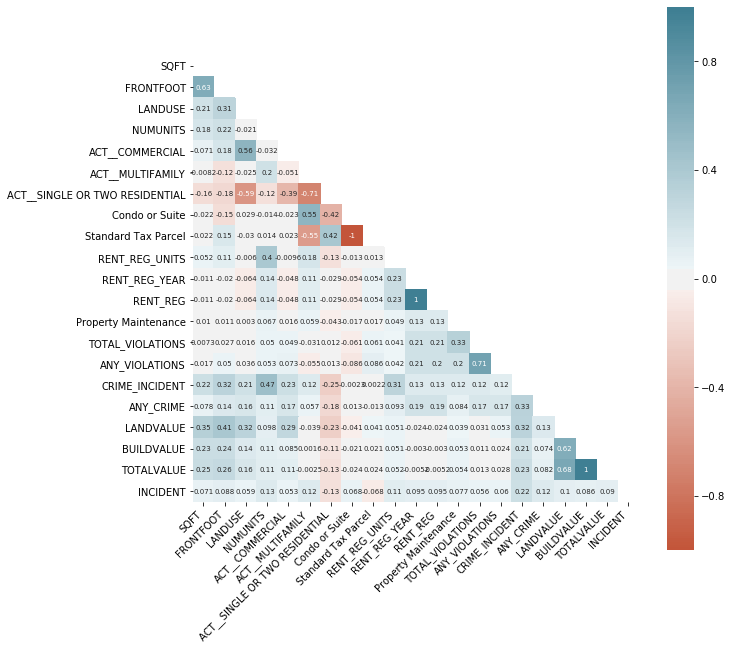

In [17]:
# Correlation heat map with our predictive variables
comb = pd.concat([X, y], axis = 1)
corr = comb.corr()

plt.figure(figsize = (10,10))

dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True


ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True, annot_kws={"size": 7},
    mask=dropSelf
)


ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.savefig('Results - Correlation matrix.pdf', bbox_inches = 'tight', pad_inches = 2.5)

## Cross validation and 2018 fire prediction accuracy

In [18]:
# Cross validation score for Random Forest
Score = cross_val_score(random_forest, X, y, cv=3)
round(np.mean(Score)*100, ndigits=4)

98.1502

In [19]:
# Assign a probability score to each address
df['PREDICTION'] =  random_forest.predict_proba(X)[:,1]
df.PREDICTION.describe()

count    55248.000000
mean         0.018395
std          0.057942
min          0.001134
25%          0.005648
50%          0.006841
75%          0.012729
max          0.989337
Name: PREDICTION, dtype: float64

In [20]:
# Compare fires found in 2018 in the 2000 highest risk properties versus randomness
np.random.seed(0)
df['RANDOM'] = np.random.rand(df.shape[0])
df_random = df.nlargest(2000, columns = 'RANDOM')

rf_results_search = df.nlargest(2000, columns = 'PREDICTION')
print('Total 2018 predicted fires (2000 interventions): ' + str(rf_results_search.INCIDENT_2018.sum()))
print('Total random predicted fires (2000 interventions): ' + str(df_random.INCIDENT_2018.sum()))

Total 2018 predicted fires (2000 interventions): 42
Total random predicted fires (2000 interventions): 6


## Describe and export the results

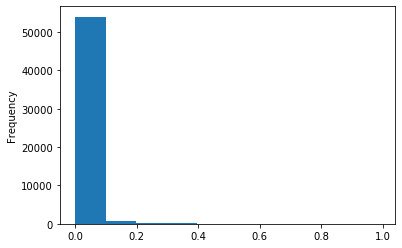

In [21]:
# Visualize how fire risk is distributed among parcel addresses
df.PREDICTION.plot.hist()

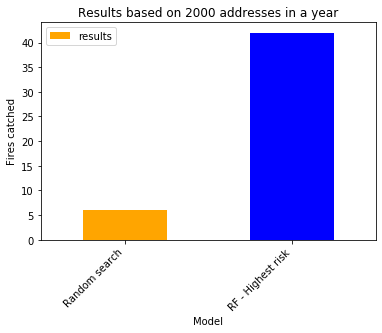

In [22]:
# Plotting the comparison between randomness and sorting by highest risk with our algorithm
random_results = df_random.INCIDENT_2018.sum()

rf_results = rf_results_search.INCIDENT_2018.sum()

df_results = pd.DataFrame({'Model' : ['Random search', 'RF - Highest risk'], 'results' : [random_results, rf_results]})
ax = df_results.plot.bar(x = 'Model', y = 'results', color = ['orange', 'b'])

plt.title('Results based on 2000 addresses in a year')
plt.ylabel('Fires catched')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)


plt.savefig('Results - Model comparison.pdf', bbox_inches = 'tight', pad_inches = 0.5)

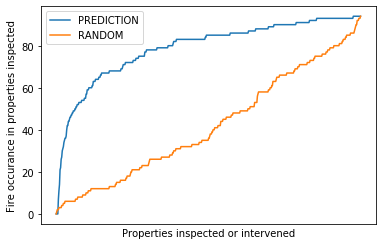

In [23]:
# Comparing our predictive model to randomness
model_comparison = []

for searches in range(0, 55000, 100):
    prediction = df.nlargest(searches, columns = 'PREDICTION').INCIDENT_2018.sum()
    random = df.nlargest(searches, columns = 'RANDOM').INCIDENT_2018.sum()
    model_comparison.append([prediction, random])
    
model_comparison_df = pd.DataFrame(model_comparison, columns=['PREDICTION', 'RANDOM'])

model_comparison_df.plot()
plt.xlabel('Properties inspected or intervened')
plt.ylabel('Fire occurance in properties inspected')
plt.xticks([])

plt.savefig('Model comparison - properties intervened.pdf', bbox_inches = 'tight', pad_inches = 2.5)

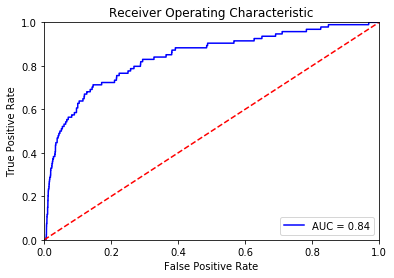

In [24]:
# ROC graph
y_test = df.INCIDENT_2018
preds = df.PREDICTION

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('AUC ROC curve.pdf', bbox_inches = 'tight', pad_inches = 2.5)

In [25]:
# Feature importance from the RFC 
feature_importances = pd.DataFrame(random_forest.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',                                                                 
                                                                        ascending=False)
feature_importances

,importance
CRIME_INCIDENT,0.202975
SQFT,0.185457
FRONTFOOT,0.095755
NUMUNITS,0.072335
TOTALVALUE,0.066862
BUILDVALUE,0.063689
LANDVALUE,0.062413
LANDUSE,0.056735
RENT_REG_UNITS,0.037084
RENT_REG_YEAR,0.026956


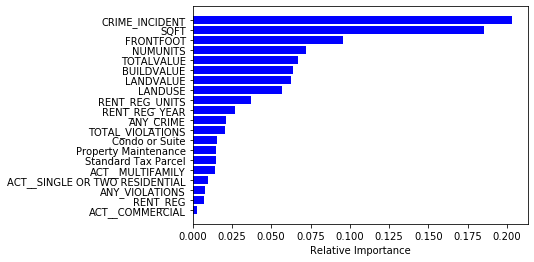

In [26]:
# Visualizing the feature importances through a graph
importances = random_forest.feature_importances_
indices = np.argsort(importances)
ax = plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig('Results - Feature importance.pdf', bbox_inches = 'tight', pad_inches = 0.5)

In [27]:
# Export the results to CSV
df['PREDICTION'].to_csv('Results - risk predictions.csv', header = True)

## Have any questions? Email me at nsdiaz@uc.cl